## Disponível online

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/carlos-adir/UnB-Courses/blob/dev/mntf/fem-nurbsnD.ipynb)

Esse python notebook está disponível online no GitHub através do link:

* [GitHub/carlos-adir/UnB-Courses/mntf/fem-nurbsnD](https://github.com/carlos-adir/UnB-Courses/blob/dev/mntf/fem-nurbsnD.ipynb)

In [1]:
import os
os.system("pip install numpy")
os.system("pip install matplotlib")
os.system("pip install compmec-nurbs")
import numpy as np
import sympy as sp
import math
from typing import Callable, Iterable, Optional, Tuple
from matplotlib import pyplot as plt
from compmec import nurbs  
from helper import getH, getD, solve_system, plot_field

# Teoria

Até então fizemos o Método dos Elementos Finitos (FEM) usando BSplines para 1D. Ou seja, até então tratamos EDOs.

### Recapitulação sobre BSplines

Recapitulando, usamos funções de base BSplines com um vetor de nós $U$:

$$
U = \left[u_0, \ u_1, \ \cdots, \ u_p, \ u_{p+1}, \ \cdots, \ u_{n-1}, \ u_{n}, \ \cdots, \ u_{n+p}\right]
$$
$$
0 = u_0 = u_1 = \cdots = u_{p} < u_{p+1} \le \cdots \le u_{n-1} < u_{n} = \cdots = u_{n+p} = 1
$$

Em que $p$ é a ordem do polinômio. Desta forma, teremos $p+1$ vetores de $n$ funções:

$$
\left[N_{\text{all}}\right] = 
\begin{bmatrix}
N_{00}(u) & N_{10}(u) & \cdots & N_{n-1, 0}(u) \\ 
N_{01}(u) & N_{11}(u) & \cdots & N_{n-1, 1}(u) \\ 
\vdots & \vdots & \ddots & \vdots \\ 
N_{0p}(u) & N_{1p}(u) & \cdots & N_{n-1, p}(u) \\ 
\end{bmatrix}
$$

Uma notação que usamos é que

$$
\left[N_{j}\right] = \begin{bmatrix}N_{0j} & N_{1j} & \cdots & N_{n-2,j} & N_{n-1,j}\end{bmatrix} \ \ \ \ \ \ \ \forall \ 0 \le j \le p
$$

Como $N_{ij}(u) = 0 \ \forall i=\left\{0, \ \cdots, \ p-j\right\}$, então podemos substituir e escrever

$$
\left[N_{\text{all}}\right] = 
\begin{bmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & N_{p,0} & \cdots & N_{n-1, 0} \\ 
0 & 0 & 0 & \cdots & 0 & N_{p-1, 1} & N_{p,1} & \cdots & N_{n-1, 1} \\ 
0 & 0 & 0 & \cdots & N_{p-2, 2} & N_{p-1, 1} & N_{p,1} & \cdots & N_{n-1, 1} \\ 
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\ 
0 & 0 & N_{2,p-2} & \cdots & N_{p-2,p-2} & N_{p-1,p-2} & N_{p,p-2} & \cdots & N_{n-1, p} \\ 
0 & N_{1,p-1} & N_{2,p-1} & \cdots & N_{p-2,p-1} & N_{p-1,p-1} & N_{p,p-1} & \cdots & N_{n-1, p} \\ 
N_{0p} & N_{1p} & N_{2p} & \cdots & N_{p-2,p} & N_{p-1,p} & N_{p,p} & \cdots & N_{n-1, p} \\ 
\end{bmatrix}
$$

Assim, a solução que procuramos é descrita da forma

$$
w(u) = \sum_{i=0}^{n-1} w_{i} \cdot N_{ip}(u) = \left[N_p\right] \cdot \left[w\right]
$$

Como lidamos com derivadas, vimos também que a derivada se comporta da forma:

$$
\dfrac{dw}{du} = \left[\dfrac{dN_p}{du}\right] \cdot \left[w\right] = \left[D_p\right] \cdot \left[N_{p-1}\right] \cdot \left[w\right]
$$
$$
\dfrac{d^2w}{du^2} = \left[\dfrac{d^2N_p}{du^2}\right] \cdot \left[w\right] = \left[D_p\right] \cdot \left[D_{p-1}\right] \cdot \left[N_{p-2}\right] \cdot \left[w\right]
$$

Em que 

$$\alpha_{ij} =  \begin{cases} \dfrac{j}{u_{i+j}-u_{i}} \ \ \ \text{if} \ u_{i} \ne u_{i+j} \\
0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{else}\end{cases}$$
$$\left[D_{j}\right] = \begin{bmatrix}
\alpha_{0j} & -\alpha_{1j} & & & \\
& \alpha_{1j} & -\alpha_{2j} & & \\
& & \alpha_{2j} & -\alpha_{3j} & \\
& & & \ddots & \ddots & \\
& & & & \alpha_{n-1,j} & -\alpha_{n,j} \\
& & & & & \alpha_{nj}
\end{bmatrix}$$

Para elementos finitos é importante integrar, de forma que 

$$
\left[H_{yz}\right]_{n \times n} = \int_{0}^{1} \left[N_{y}\right] \otimes \left[N_{z}\right] \ du = \sum_{k=p}^{n-1} \left[H_{yz}^{(k)}\right]
$$
$$
\left[H_{yz}^{(k)}\right]_{(n \times n)} = \int_{u_k}^{u_{k+1}} \left[N_{y}\right] \otimes \left[N_{z}\right] \ du = \left(u_{k+1}-u_{k}\right)
\begin{bmatrix} \left[0\right] & \left[0\right] & \left[0\right] \\ \left[0\right] & \left[M_{yz}^{(k)}\right] & \left[0\right] \\ \left[0\right] & \left[0\right] & \left[0\right] \end{bmatrix}
$$
$$
\left[M_{yz}^{(k)}\right]_{(y+1)\times(z+1)} = \dfrac{1}{u_{k+1}-u_{k}} \int_{u_k}^{u_{k}}
\begin{bmatrix}
N_{k-y,y}N_{k-z,z} & N_{k-y,y}N_{k-z+1,z} & \cdots & N_{k-y,y}N_{k,z} \\ 
N_{k-y+1,y}N_{k-z,z} & N_{k-y+1,y}N_{k-z+1,z} & \cdots & N_{k-y+1,y}N_{k,z} \\ 
\vdots & \vdots & \cdots & \vdots \\ 
N_{k,y}N_{k-z,z} & N_{k,y}N_{k-z+1,z} & \cdots & N_{k,y}N_{k,z} \\ 
\end{bmatrix} \ du
$$

Para valores de $y$ e $z$ pequenos, teremos:

$$
\left[M_{00}^{(k)}\right] = \begin{bmatrix} 1 \end{bmatrix}
$$
$$
\left[M_{01}^{(k)}\right] = \dfrac{1}{2}\begin{bmatrix} 1 & 1 \end{bmatrix}
$$
$$
\left[M_{11}^{(k)}\right] = \dfrac{1}{6}\begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}
$$

Já para valores maiores, é necessário investigar, mas já existe uma função ```getMatrix(y, z, k, N)``` que já entrega o valor de $[M_{yz}]$ usando integrais numéricas.

### Notação

Podemos aplicar BSplines para qualquer EDO e EDP. Elas podem ser de varias variáveis, varios tipos de problemas, diferentes formulações. Contudo, para problemas físicos, as variáveis mais clássicas são as três espaciais $(x, \ y, \ z)$ e o tempo $t$.

Assim, aplicamos a ordem de variavéis:

$$x \to y \to z \to t$$

Para a notação indicial, de somatórios e etc, utilizaremos sempre a convenção de:

$$
\begin{matrix}
x \longrightarrow i, \ a \\
y \longrightarrow j, \ b \\
z \longrightarrow k, \ c \\
t \longrightarrow l, \ d \\
\end{matrix}
$$

Do mesmo modo, se tivermos um domínio $$\Omega = \left[0, 1\right] \times \left[0, \ 1\right]$$ isso implica que pode ser (dependendo da EDP tratada):

$$
\begin{matrix}
\Omega_{xy} = \underbrace{\left[0, 1\right]}_{x} \times \underbrace{\left[0, \ 1\right]}_{y}  \\
\Omega_{xz} = \underbrace{\left[0, 1\right]}_{x} \times \underbrace{\left[0, \ 1\right]}_{z}  \\
\Omega_{xt} = \underbrace{\left[0, 1\right]}_{x} \times \underbrace{\left[0, \ 1\right]}_{t}  \\
\Omega_{yz} = \underbrace{\left[0, 1\right]}_{y} \times \underbrace{\left[0, \ 1\right]}_{z}  \\
\Omega_{yt} = \underbrace{\left[0, 1\right]}_{y} \times \underbrace{\left[0, \ 1\right]}_{t}  \\
\Omega_{zt} = \underbrace{\left[0, 1\right]}_{z} \times \underbrace{\left[0, \ 1\right]}_{t}  \\
\end{matrix}
$$

# Aplicação FEM com BSplines na equação de Poisson

Agora, seja a equação de Poisson dada por

$$
\mu \dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial T}{\partial t} = f(x, \ t) \ \ \ \ \ \ \ \ \ \text{on} \ \Omega_{xt}
$$

Com $\mu \in \mathbb{R}$ e dominio retangular $$\Omega_{xt} = \left[0, \ 1 \right]\left[0, \ 1\right]$$

Queremos encontrar uma solução aproximada da forma

$$
T(x, t) = \sum_{i=0}^{n_{x}-1} \sum_{l=0}^{n_t-1} N_{i,px}(x) \cdot  N_{l,pt}(t) \cdot T_{i,l}
$$
$$
T(x, t) = \left[N_{px}\right] \left[T\right] \left[N_{pt}\right]
$$

Com $n_x \times n_t$ valores $T_{il}$ desconhecidos.
Assim, aplicando na formulação de elementos finitos:

$$
\int_{\Omega} \left(\dfrac{\partial T}{\partial t} - \mu \dfrac{\partial^2 T}{\partial x^2} - f\right) \cdot \varphi \ d\Omega  \ \ \ \ \ \ \ \ \forall \varphi
$$

Obtemos o sistema linear:

$$
\sum_{a=0}^{n_x-1} \sum_{d=0}^{n_t-1} A_{i,a,l,d} \cdot T_{a,d} = B_{i, l} \ \ \ \ \  \forall i,  \ l
$$

$$
A_{i, a, l, d} = \int_{\Omega} N_{i,px}N_{l,pt} \left(\mu \dfrac{d^2 N_{a,px}}{dx^2} N_{d,pt} + N_{a,px}\dfrac{dN_{d,pt}}{dt} \right) \ d\Omega
$$
$$
B_{i, l} = \int_{\Omega} N_{i,px}N_{l,pt} f \ d\Omega
$$

A inicio as contas podem parecer complicadas, mas basta um pouco de trabalho:

> Para a matriz $A$, vemos que as integrais são separáveis:
> 
> $$A_{i,a,l,d} = \mu \left(\int_{0}^{1} N_{i,px} \frac{d^2N_{a,px}}{dx^2}\ dx\right)\left(\int_{0}^{1} N_{l,pt} N_{d,pt}\ dt\right) + \left(\int_{0}^{1} N_{i,px} N_{a,px}\ dx\right)\left(\int_{0}^{1} N_{l,pt} \frac{dN_{d,pt}}{dt}\ dt\right) $$
> 
> Que já vimos anteriormente que essas integrais são já conhecidas do caso 1D:
> 
> $$\int_{0}^{1} N_{i,px}(x)N_{a,px}(x) \ dx = \left[H_{px,px}\right]_{i,a}$$
> $$\int_{0}^{1} N_{l,pt}(t)N_{d,pt}(t) \ dt = \left[H_{pt,pt}\right]_{l,d}$$
> $$\int_{0}^{1} N_{l,pt}(t)\dfrac{dN_{d,pt}}{dt}(t) \ dt = \left(\left[H_{pt-1,pt}\right]^{T}\left[D_{pt}\right]^{T}\right)_{l,d}$$
> $$\int_{0}^{1} N_{i,px}(x)\dfrac{d^2N_{a,px}}{dx^2} \ dx = \left( \left[X_{bound}\right] \left[D_{px}\right]^{T} - \left[D_{px}\right] \left[H_{px-1,px-1}\right] \left[D_{px}\right]^{T}\right)_{i,a}$$
> $$X_{bound} = \left(\left[N_{px}\right] \otimes \left[N_{px-1}\right]\right)_{0}^{1}$$
> 
> Logo se tem
> 
> $$\begin{align*}
\left[A\right] & = \left(\left[H_{px, px}\right] \otimes \left[H_{pt-1,pt}\right]^{T}\left[D_{pt}\right]^{T}\right)\\ 
& - \mu \left(\left[D_{px}\right] \left[H_{px-1,px-1}\right] \left[D_{px}\right]^{T}\right) \otimes \left[H_{pt, pt}\right] \\
& + \mu \left( \left[X_{bound}\right] \left[D_{px}\right]^{T} \right) \otimes \left[H_{pt, pt}\right]
\end{align*}$$

Já para $B$, temos

> $$B_{i,l} = \int_{\Omega}N_{i,px}N_{l,pt} f \ d\Omega$$
> 
> Nós aproximamos $f(x, t)$ por uma Superfície BSpline
> 
> $$g(x, t) = \sum_{a=0}^{n_x-1}\sum_{d=0}^{n_t-1}N_{a,px}(x) \cdot N_{d,pt}(t) \cdot G_{a,d} \approx f(x, t)$$
> 
> Então seja um vetor com valores $\vec{x}$ e outro com valores $\vec{t}$, calculamos
> 
> $$\left[F\right]_{i,l}  = F_{i,l}= f\left(x_i, \ t_{l}\right) $$
> $$\left[L_{x}\right] = \left[N_{px}(\vec{x})\right]$$
> $$\left[L_{t}\right] = \left[N_{pt}(\vec{t})\right]$$
> $$\left[F\right] \approx \left[L_x\right]^{T} \left[G\right]  \left[L_{t}\right]$$
> $$\left[G\right] = \left(\left[L_x\right]\left[L_x\right]^{T}\right)^{-1} \left[L_x\right]\left[F\right]\left[L_t\right]^{T} \left(\left[L_t\right]\left[L_t\right]^{T}\right)^{-1}$$
> Então aplicando em $B$
> $$\begin{align*}B_{i, l} & = \int_{\Omega} N_{i,px}N_{l,pt} \sum_{a=0}^{n_x-1}\sum_{d=0}^{n_t-1}N_{a,px}(t) N_{d,pt}(x)G_{a,d} \ d\Omega \\ & = \sum_{a=0}^{n_x-1} \sum_{d=0}^{n_t-1} \left(\int_\Omega  N_{i,px}N_{l,pt}N_{a,px} N_{d,pt} \ d\Omega \right)  G_{a,d} \\ & = \sum_{a=0}^{n_x-1} \sum_{d=0}^{n_t-1} \left(\int_{0}^{1} N_{i,px}N_{a,px} \ dx\right)\left(\int_{0}^{1} N_{l,pt} N_{d,pt} \ dt\right) G_{a,d}\\ & = \sum_{a=0}^{n_x-1} \sum_{d=0}^{n_t-1} \left[H_{px, px}\right]_{i,a}\left[H_{pt,pt}\right]_{l,d} \cdot G_{a,d} \\ & = \left( \left[H_{px,px}\right] \left[G\right] \left[H_{pt, pt}\right]^{T}\right)_{i,l}\end{align*}$$
> Ou seja, como resultado final tem-se
> $$\left[B\right] = \left[H_{px,px}\right] \left[G\right] \left[H_{pt, pt}\right]^{T}$$

Agora vamos calcular

In [2]:
def mountA(Nx, Nt, mu: float) -> np.ndarray:
    px, pt = Nx.degree, Nt.degree
    Ux, Ut = Nx.knotvector, Nt.knotvector
    Hpxpx = getH(px, px, Nx)
    Hptpt = getH(pt, pt, Nt)
    Hpx1px1 = getH(px-1, px-1, Nx)
    Hptpt1 = getH(pt, pt-1, Nt)
    Dpx = getD(px, Ux)
    Dpt = getD(pt, Ut)
    Xbound = np.tensordot(Nx[:, px](1), Nx[:, px-1](0), axes=0)
    Xbound -= np.tensordot(Nx[:, px](0), Nx[:, px-1](0), axes=0)
    A = np.tensordot(Hpxpx, Hptpt1 @ Dpt.T, axes=0)
    A -= mu*np.tensordot(Dpx @ Hpx1px1 @ Dpx.T, Hptpt, axes=0)
    A += mu*np.tensordot(Xbound @ Dpx.T, Hptpt, axes=0)
    return A

def mountB(Nx, Nt, xsample, tsample, f) -> np.ndarray:
    nx, nt = Nx.npts, Nt.npts
    px, pt = Nx.degree, Nt.degree
    Lx = Nx(xsample)
    Lt = Nt(tsample)
    F = np.zeros((len(xsample), len(tsample)))
    for i, xi in enumerate(xsample):
        for l, tl in enumerate(tsample):
            F[i, l] = f(xi, tl)
    if np.all(F == 0):
        return np.zeros((nx, nt), dtype="float64")
    G = np.linalg.inv(Lx @ Lx.T) @ Lx @ F @ Lt.T @ np.linalg.inv(Lt @ Lt.T)
    Hpxpx = getH(px, px, Nx)
    Hptpt = getH(pt, pt, Nt)
    B = Hpxpx @ G @ Hptpt
    return B
    

### Exercício 1

> $$\dfrac{\partial T}{\partial t} = \dfrac{\partial^2 T}{\partial x^2} \ \ \ \ \ \text{on} \ \Omega$$
>
> No domínio 
> 
> $$\Omega = \underbrace{\left[0, \ 1\right]}_{x} \times \underbrace{\left[0, \ 1\right]}_{t}$$
> 
> E condições de contorno
> 
> $$T(0, \ t) = T(1, \ t) = 0 \ \ \ \ \ 0 \le t \le 1$$
> $$T(x, \ 0) = \sin \left(\pi x\right) \ \ \ \ 0 \le x \le 1$$
> 
> A solução exata é dada por
> 
> $$T_{exact}(x, \ t) = \exp \left(-\pi^2 t\right) \cdot \sin \left(\pi x\right)$$


In [3]:
nx, nt = 33, 33
px, pt = 5, 4
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Ut = nurbs.GeneratorKnotVector.uniform(pt, nt)
Nx = nurbs.SplineBaseFunction(Ux)
Nt = nurbs.SplineBaseFunction(Ut)
xsample = np.linspace(0, 1, 4*nx)
tsample = np.linspace(0, 1, 4*nt)
Lx, Lt = Nx(xsample), Nt(tsample)

Tvals = np.empty((nx, nt))
Tvals.fill(np.nan)
Tvals[0, :] = 0
Tvals[-1, :] = 0
Tvals[:, 0] = np.linalg.lstsq(Lx.T, np.sin(np.pi*xsample), rcond=None)[0]

f = lambda x, t: 0
A = mountA(Nx, Nt, -1)
B = mountB(Nx, Nt, xsample, tsample, f)
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'Erro')

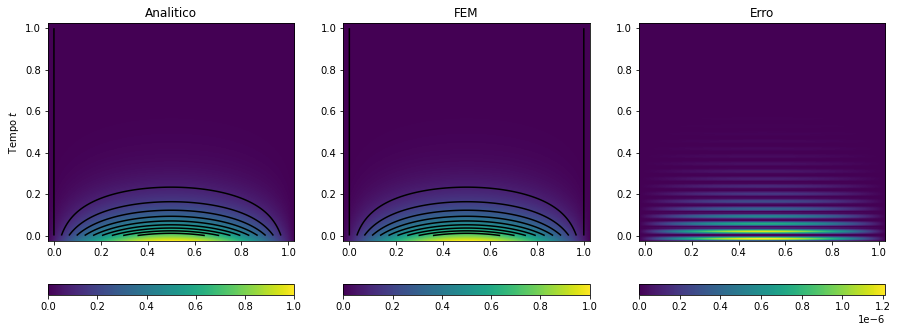

In [4]:
xplot = np.linspace(0, 1, 1025)
tplot = np.linspace(0, 1, 1025)
Lx, Lt = Nx(xplot), Nt(tplot)

femvalues = Lx.T @ Tvals @ Lt
exavalues = np.tensordot(np.sin(np.pi*xplot), np.exp(-np.pi**2 * tplot), axes=0)
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, tplot, exavalues, axis[0])
plot_field(xplot, tplot, femvalues, axis[1])
plot_field(xplot, tplot, np.abs(femvalues-exavalues), axis[2], contour=False)
axis[0].set_ylabel(r"Tempo $t$")
axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[2].set_title("Erro")

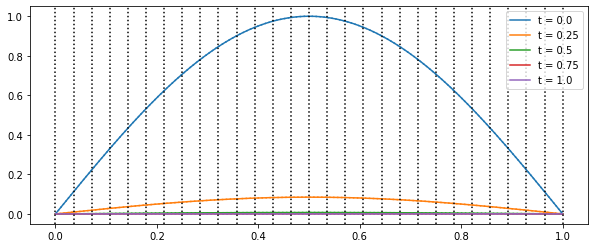

In [5]:
ncurves = 5
indexstime = [int(curveindex) for curveindex in np.linspace(0, len(tplot)-1, ncurves)]
plt.figure(figsize=(10, 4))
for j in indexstime:
    pl = plt.plot(xplot, exavalues[:, j], ls="dotted")
    color = pl[0].get_color()
    plt.plot(xplot, femvalues[:, j], label=f"t = {tplot[j]:.2}", color=color)
[plt.axvline(x=xi, color="k", ls="dotted") for xi in list(set(Ux))]
plt.legend()

### Exercício 2

> $$\dfrac{\partial T}{\partial t} = \dfrac{\partial^2 T}{\partial x^2} \ \ \ \ \ \text{on} \ \Omega$$
> 
> No dominio 
> 
> $$\Omega = \underbrace{\left[0, \ 1\right]}_{x} \times \underbrace{\left[0, \ \infty\right)}_{t}$$
> 
> E condições de contorno
> 
> $$T(0, \ t) = T(1, \ t) = 0 \ \ \ \ \ \forall 0 \le t$$
> 
> $$T(x, \ 0) = 1 \ \ \ \ 0 < x < 1$$
> 
> A solução exata é dada por
> 
> $$T_{exact}(x, \ t) = \sum_{n=1}^{\infty} \dfrac{4}{(2n-1)\pi} \cdot \exp \left(-(2n-1)^2\pi^2 t\right) \cdot \sin \left((2n-1)\pi x\right)$$

Então encontramos a solução numérica

In [6]:
mu = -1
nx, nt = 21, 11
px, pt = 3, 2
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Ut = nurbs.GeneratorKnotVector.uniform(pt, nt)
Nx = nurbs.SplineBaseFunction(Ux)
Nt = nurbs.SplineBaseFunction(Ut)
xsample = np.linspace(0, 1, 4*nx)
tsample = np.linspace(0, 1, 4*nt)

Tvals = np.empty((nx, nt))
Tvals.fill(np.nan)
Tvals[0, :] = 0  # T(0, t) = 0
Tvals[-1, :] = 0  # T(1, t) = 0
Tvals[1:-1, 0] = 1  # T(x, 0) = 1

f = lambda x, t: 0
A = mountA(Nx, Nt, -1)
B = mountB(Nx, Nt, xsample, tsample, f)
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'Erro')

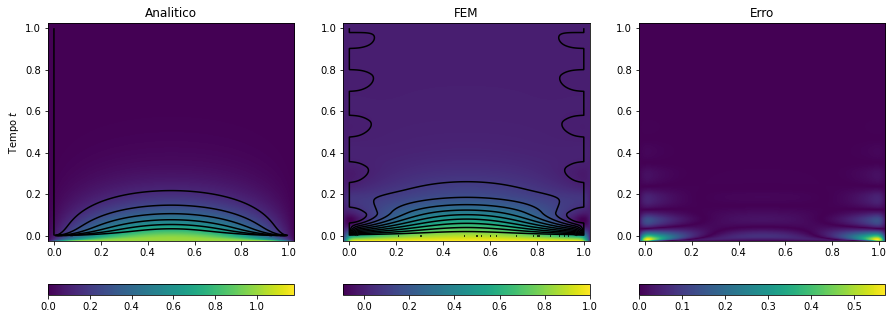

In [7]:
xplot = np.linspace(0, 1, 1025)
tplot = np.linspace(0, 1, 1025)
Lx, Lt = Nx(xplot), Nt(tplot)

femvalues = Lx.T @ Tvals @ Lt
exavalues = 0
for n in range(1, 21):
    sinpart = np.sin((2*n-1)*np.pi*xplot)
    exppart = np.exp(-(2*n-1)**2*(np.pi**2)*tplot)
    exavalues += np.tensordot(sinpart, exppart, axes=0)/(2*n-1)
exavalues *= 4/np.pi

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, tplot, exavalues, axis[0])
plot_field(xplot, tplot, femvalues, axis[1])
plot_field(xplot, tplot, np.abs(femvalues-exavalues), axis[2], contour=False)
axis[0].set_ylabel(r"Tempo $t$")
axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[2].set_title("Erro")

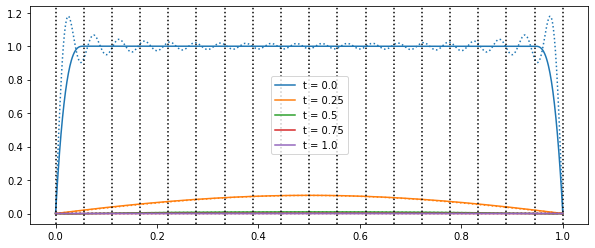

In [8]:
ncurves = 5
indexstime = [int(curveindex) for curveindex in np.linspace(0, len(tplot)-1, ncurves)]
plt.figure(figsize=(10, 4))
for j in indexstime:
    pl = plt.plot(xplot, exavalues[:, j], ls="dotted")
    color = pl[0].get_color()
    plt.plot(xplot, femvalues[:, j], label=f"t = {tplot[j]:.2}", color=color)
[plt.axvline(x=xi, color="k", ls="dotted") for xi in list(set(Ux))]
plt.legend()

### Exercicio 3

> $$\dfrac{\partial T}{\partial t} = \dfrac{\partial^2 T}{\partial x^2} \ \ \ \ \ \text{on} \ \Omega$$
> 
> No domínio 
> 
> $$\Omega = \underbrace{\left[0, \ 1\right]}_{x} \times \underbrace{\left[0, \ \infty\right)}_{t}$$
> 
> E condições de contorno
> 
> $$T(0, \ t) = 1 \ \ \ \ \ \forall 0 \le t$$
> $$T(1, \ t) = 0 \ \ \ \ \ \forall 0 \le t$$
> 
> $$T(x, \ 0) = 0 \ \ \ \ 0 < x < 1$$
> 
> A solução exata é dada por
> 
> $$T_{exact}(x, \ t) = 1-x-\sum_{n=1}^{\infty} \dfrac{2}{n\pi} \cdot \exp \left(-n^2\pi^2 t\right) \cdot \sin \left(n\pi x\right)$$

Então resolvemos numericamente

In [9]:
nt, nx = 17, 21
pt, px = 2, 3
Ut = nurbs.GeneratorKnotVector.uniform(pt, nt)
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Nt = nurbs.SplineBaseFunction(Ut)
Nx = nurbs.SplineBaseFunction(Ux)
xsample = np.linspace(0, 1, 4*nx)
tsample = np.linspace(0, 1, 4*nt)
Lx, Lt = Nx(xsample), Nt(tsample)

Tvals = np.empty((nx, nt))
Tvals.fill(np.nan)
Tvals[:, 0] = 0  # T(x, 0) = 0
Tvals[0, :] = 1  # T(0, t) = 1
Tvals[-1, :] = 0  # T(1, t) = 0

f = lambda x, t: 0
A = mountA(Nx, Nt, -1)
B = mountB(Nx, Nt, xsample, tsample, f)
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'Erro')

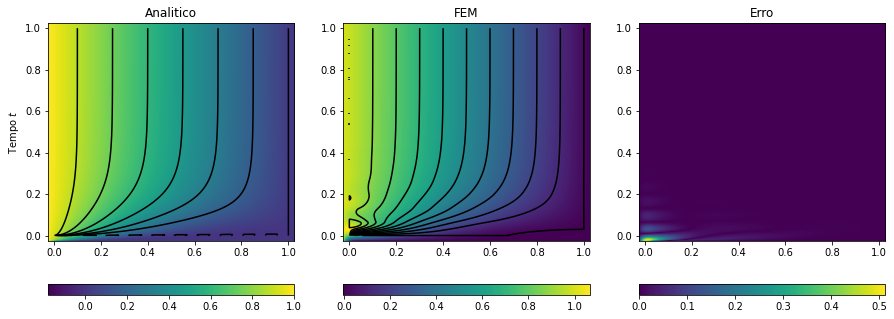

In [10]:
xplot = np.linspace(0, 1, 1025)
tplot = np.linspace(0, 1, 1025)
Lx, Lt = Nx(xplot), Nt(tplot)

femvalues = Lx.T @ Tvals @ Lt
exavalues = 0
for n in range(1, 21):
    sinpart = np.sin(n*np.pi*xplot)
    exppart = np.exp(-n**2*(np.pi**2)*tplot)
    exavalues -= np.tensordot(sinpart, exppart, axes=0)/n
exavalues *= 2/np.pi
for i, xi in enumerate(xplot):
    exavalues[i, :] += 1-xi

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, tplot, exavalues, axis[0])
plot_field(xplot, tplot, femvalues, axis[1])
plot_field(xplot, tplot, np.abs(femvalues-exavalues), axis[2], contour=False)
axis[0].set_ylabel(r"Tempo $t$")
axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[2].set_title("Erro")

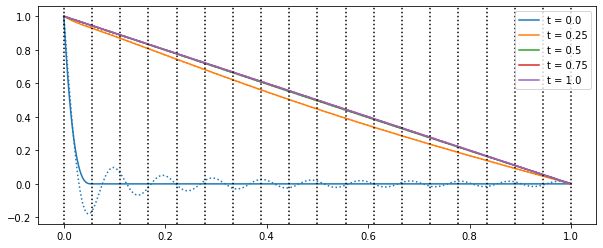

In [11]:
ncurves = 5
indexstime = [int(curveindex) for curveindex in np.linspace(0, len(tplot)-1, ncurves)]
plt.figure(figsize=(10, 4))
for j in indexstime:
    pl = plt.plot(xplot, exavalues[:, j], ls="dotted")
    color = pl[0].get_color()
    plt.plot(xplot, femvalues[:, j], label=f"t = {tplot[j]:.2}", color=color)
[plt.axvline(x=xi, color="k", ls="dotted") for xi in list(set(Ux))]
plt.legend()

### Exercicio 4

> $$\dfrac{\partial T}{\partial t} = 0.01\cdot \dfrac{\partial^2 T}{\partial x^2} \ \ \ \ \ \text{on} \ \Omega$$
> 
> No dominio
> 
> $$\Omega = \underbrace{\left[0, \ 1\right]}_{x} \times \underbrace{\left[0, \ \infty\right)}_{t}$$
> 
> E condições de contorno
> 
> $$T(0, \ t) = 0 \ \ \ \ \ \forall 0 \le t$$
> $$T(1, \ t) = 0 \ \ \ \ \ \forall 0 \le t$$
> 
> $$T(x, \ 0) = \begin{cases} 200x \ \ \  \ \ \  \ \ \  \ \ \ \text{if}  \ \ \ \ 0 \le x \le 0.5 \\
200(1-x) \ \ \text{if} \ \ \ \  0.5 < x \le 1 \end{cases}$$
> 
> A solução analítica é dada por
> 
> $$T_{exact}(x, \ t) = \dfrac{800}{\pi^2}\sum_{n=0}^{\infty} \dfrac{(-1)^{n}}{(2n+1)^2} \cdot \exp \left(-(2n+1)^2\pi^2 \cdot 0.01 \cdot t\right) \cdot \sin \left((2n+1)\pi x\right)$$

Então resolvemos numericamente

In [12]:
nt, nx = 11, 13
pt, px = 2, 3
Ut = nurbs.GeneratorKnotVector.uniform(pt, nt)
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
if 0.5 not in Ux:
    Ux.knot_insert(0.5, px)  # Pois neste ponto a funcao eh classe C0 apenas
else:
    Ux.knot_insert(0.5, px-1)  # Pois neste ponto a funcao eh classe C0 apenas
Nt = nurbs.SplineBaseFunction(Ut)
Nx = nurbs.SplineBaseFunction(Ux)
xsample = np.linspace(0, 1, 4*nx)
tsample = np.linspace(0, 1, 4*nt)
Lx, Lt = Nx(xsample), Nt(tsample)
nx, nt = Nx.npts, Nt.npts

Tvals = np.empty((nx, nt))
Tvals.fill(np.nan)
Tvals[0, :] = 0  # T(0, t) = 0
Tvals[nx-1, :] = 0  # T(1, t) = 0
x_at_0 = 200 * ( xsample * (xsample <= 0.5) + (1-xsample) * (0.5 < xsample) )
Tvals[:, 0] = np.linalg.lstsq(Lx.T, x_at_0, rcond=0)[0]

f = lambda x, t: 0
A = mountA(Nx, Nt, -0.01)
B = mountB(Nx, Nt, xsample, tsample, f)
Tvals, _ = solve_system(A, B, Tvals)

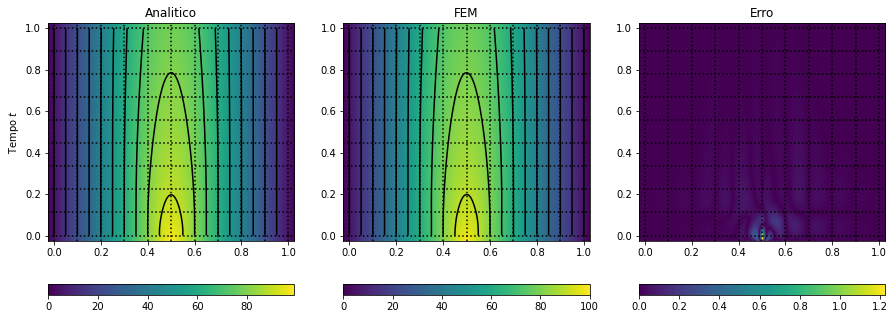

In [13]:
xplot = np.linspace(0, 1, 1025)
tplot = np.linspace(0, 1, 1025)
Lx, Lt = Nx(xplot), Nt(tplot)

femvalues = Lx.T @ Tvals @ Lt
exavalues = 0
for n in range(0, 21):
    sinpart = np.sin((2*n+1)*np.pi*xplot)
    exppart = np.exp(-(2*n+1)**2*(np.pi**2)*0.01*tplot)
    exavalues += (-1)**n * np.tensordot(sinpart, exppart, axes=0)/((2*n+1)**2)
exavalues *= 800/(np.pi**2)

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, tplot, exavalues, axis[0])
plot_field(xplot, tplot, femvalues, axis[1])
plot_field(xplot, tplot, np.abs(femvalues-exavalues), axis[2], contour=False)
axis[0].set_ylabel(r"Tempo $t$")
axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[2].set_title("Erro")
for i in range(3):
    [axis[i].axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
    [axis[i].axhline(y=ti, ls="dotted", color="k") for ti in list(set(Ut))]

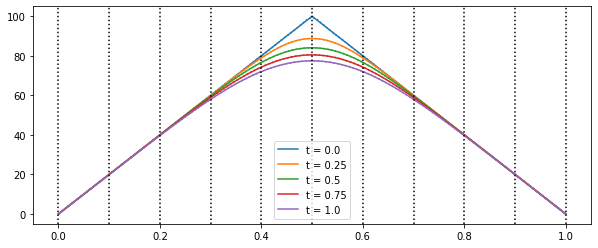

In [14]:
ncurves = 5
indexstime = [int(curveindex) for curveindex in np.linspace(0, len(tplot)-1, ncurves)]
plt.figure(figsize=(10, 4))
for j in indexstime:
    pl = plt.plot(xplot, exavalues[:, j], ls="dotted")
    color = pl[0].get_color()
    plt.plot(xplot, femvalues[:, j], label=f"t = {tplot[j]:.2}", color=color)
[plt.axvline(x=xi, color="k", ls="dotted") for xi in list(set(Ux))]
plt.legend()

### Exercicio 5

> $$\dfrac{\partial T}{\partial t} = 0.01\cdot \dfrac{\partial^2 T}{\partial x^2} \ \ \ \ \ \text{on} \ \Omega$$
>
> No dominio
> 
> $$\Omega = \underbrace{\left[0, \ 0.5\right]}_{x} \times \underbrace{\left[0, \ \infty\right)}_{t}$$
> 
> E condições de contorno
> 
> $$T(0, \ t) = 0 \ \ \ \ \ \forall \ 0 \le t$$
> $$\left[\dfrac{\partial T}{\partial x}\right]_{x=0.5}= 0 \ \ \ \ \ \forall \ 0 \le t$$
> $$T(x, \ 0) = 200x \ \ \ \ \ \forall  \ 0 \le x \le 0.5$$
> 
> A solução analítica é dada por
> 
> $$T_{exact}(x, \ t) = \dfrac{800}{\pi^2}\sum_{n=0}^{\infty} \dfrac{(-1)^{n}}{(2n+1)^2} \cdot \exp \left(-(2n+1)^2\pi^2 \cdot 0.01 \cdot t\right) \cdot \sin \left((2n+1)\pi x\right)$$

No nosso caso, o domínio em $x$ é $\left[0, \ 0.5\right]$, e não $\left[0, \ 1\right]$.
Desta forma, reescreveremos a EDP de forma

$$
y = 2x  \Rightarrow \dfrac{\partial T}{\partial x} = \dfrac{\partial T}{\partial y} \cdot \dfrac{\partial y}{\partial x} \Rightarrow \dfrac{\partial T}{\partial x} = 2\dfrac{\partial T}{\partial y} \Rightarrow \dfrac{\partial^2 T}{\partial x^2} = 4\dfrac{\partial^2 T}{\partial y^2}
$$

> $$\dfrac{\partial T}{\partial t} = 0.04\cdot \dfrac{\partial^2 T}{\partial y^2} \ \ \ \ \ \text{on} \ \Omega$$
>
> No dominio
> 
> $$\Omega = \underbrace{\left[0, \ 1\right]}_{y} \times \underbrace{\left[0, \ \infty\right)}_{t}$$
> 
> E condições de contorno
> 
> $$T(0, \ t) = 0 \ \ \ \ \ \forall \ 0 \le t$$
> $$\left[\dfrac{\partial T}{\partial y}\right]_{y=1}= 0 \ \ \ \ \ \forall \ 0 \le t$$
> $$T(y, \ 0) = 100y \ \ \ \ \ \forall  \ 0 \le y \le 1$$
> 
> A solução analítica é dada por
> 
> $$T_{exact}(y, \ t) = \dfrac{800}{\pi^2}\sum_{n=0}^{\infty} \dfrac{(-1)^{n}}{(2n+1)^2} \cdot \exp \left(-\left(2n+1\right)^2\pi^2 \cdot 0.01 \cdot t\right) \cdot \sin \left(\left(n+\frac{1}{2}\right)\pi y\right)$$

Para a condição de Neumann em $y = 1$ teremos

$$T = \left[N_{pt}\right] \left[T\right] \left[N_{px}\right]$$
$$\dfrac{\partial T}{\partial y}=\left[N_{pt}\right] \left[T\right] \left[D_{px}\right] \left[N_{px-1}\right]$$
$$\left[\dfrac{\partial T}{\partial y}\right]_{y=1} = q(t) \Rightarrow \left[N_{pt}(t)\right] \left[T\right] \left[D_{px}\right] \left[N_{px-1}(1)\right] \approx q(t) \ \ \ \ \ \ \ \forall \  t$$
$$\left[N_{pt}(t_{m})\right] \left[T\right] \left[D_{py}\right] \left[N_{py-1}(1)\right]  = q(t_{m}) \ \ \ \ \ \forall \ m$$
$$
\left[T\right]\underbrace{\left[D_{px}\right] \left[N_{px-1}(1)\right]}_{R} = \underbrace{\left(\left[N_{pt}(t)\right]\left[N_{pt}(t)\right]^{T}\right)^{-1}\left[N_{pt}(t)\right] \left[q\right]}_{W}
$$
$$
\sum_{j=0}^{n_x-1} T_{ij} \cdot R_{j} = W_{i} \ \ \forall i = 0, \ \cdots, \ n_t-1
$$
$$
A_{i,i,n_y-1,j} = R_{j} \ \ \ \ \ \ \ \ \ B_{i,n_{y}-1} = W_{i}  \  \  \forall \begin{cases}i = 0, \ \cdots, \ n_t-1 \\ j = 0, \ \cdots, \ n_y - 1\end{cases}
$$



In [15]:
mu = -0.04

ny, nt = 11, 13
py, pt = 3, 2
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
Ut = nurbs.GeneratorKnotVector.uniform(pt, nt)
Ny = nurbs.SplineBaseFunction(Uy)
Nt = nurbs.SplineBaseFunction(Ut)
ysample = np.linspace(0, 1, 4*ny)
tsample = np.linspace(0, 1, 4*nt)
Ly, Lt = Ny(ysample), Nt(tsample)
ny, nt = Ny.npts, Nt.npts

Tvals = np.empty((ny, nt))
Tvals.fill(np.nan)
Tvals[0, :] = 0  # T(0, t) = 0
Tvals[:, 0] = np.linalg.lstsq(Ly.T, 100*ysample, rcond=0)[0]  # T(y, 0) = 100*y

f = lambda x, t: 0
A = mountA(Ny, Nt, -0.04)
B = mountB(Ny, Nt, ysample, tsample, f)
# Adicionamos a condicao de contorno de Neumann quando y = 1
q_at_y1 = np.zeros(tsample.shape, dtype="float64")
B[-1, :] = np.linalg.lstsq(Lt.T, q_at_y1, rcond=None)[0]
R = getD(py, Uy) @ Ny[:,py-1](1)
for m in range(nt):
    A[-1, :, m, m] = R[:]
Tvals, _ = solve_system(A, B, Tvals)

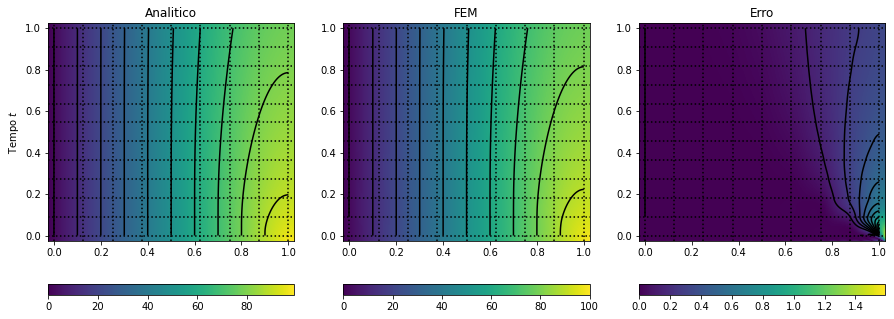

In [16]:
yplot = np.linspace(0, 1, 1025)
tplot = np.linspace(0, 1, 1025)
Ly, Lt = Ny(yplot), Nt(tplot)

femvalues = Ly.T @ Tvals @ Lt
exavalues = 0
for n in range(0, 21):
    sinpart = np.sin((n+0.5)*np.pi*yplot)
    exppart = np.exp(-(2*n+1)**2*(np.pi**2)*0.01*tplot)
    exavalues += (-1)**n * np.tensordot(sinpart, exppart, axes=0)/((2*n+1)**2)
exavalues *= 800/(np.pi**2)

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(yplot, tplot, exavalues, axis[0])
plot_field(yplot, tplot, femvalues, axis[1])
plot_field(yplot, tplot, np.abs(femvalues-exavalues), axis[2], contour=True)
axis[0].set_ylabel(r"Tempo $t$")
axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[2].set_title("Erro")
for i in range(3):
    [axis[i].axvline(x=yi, ls="dotted", color="k") for yi in list(set(Uy))]
    [axis[i].axhline(y=ti, ls="dotted", color="k") for ti in list(set(Ut))]

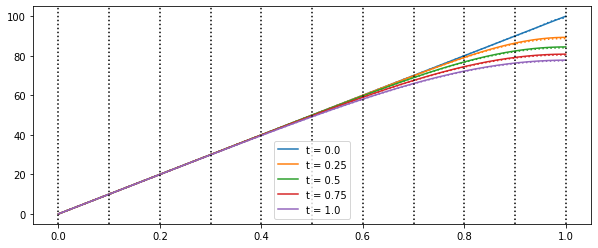

In [17]:
ncurves = 5
indexstime = [int(curveindex) for curveindex in np.linspace(0, len(tplot)-1, ncurves)]
plt.figure(figsize=(10, 4))
for j in indexstime:
    pl = plt.plot(xplot, exavalues[:, j], ls="dotted")
    color = pl[0].get_color()
    plt.plot(xplot, femvalues[:, j], label=f"t = {tplot[j]:.2}", color=color)
[plt.axvline(x=xi, color="k", ls="dotted") for xi in list(set(Ux))]
plt.legend()

# Equação do calor

Do mesmo modo feito para a equação de Poisson, teremos:

$$
\mu_x \dfrac{\partial^2 T}{\partial x^2} + \mu_y \dfrac{\partial^2 T}{\partial y^2} = f(x, \ y) \ \ \ \ \ \text{on} \ \ \Omega  
$$

Com constantes não nulas $\mu_x$, $\mu_y \in \mathbb{R}$. Usando a equação de Galerkin

$$
\int_{\Omega} \left(\mu_x\dfrac{\partial^2 T}{\partial x^2} + \mu_y\dfrac{\partial^2 T}{\partial y^2} - f\right) \cdot \varphi \ d\Omega = 0 \ \ \ \forall \varphi
$$

Fazendo as mesmas operações que antes, teremos:

$$
\int_{\Omega} \dfrac{\partial^2 T}{\partial x^2} \varphi \ d\Omega \equiv \left(\left[X_{bound}\right] \left[D_{px}\right]^{T} - \left[D_{px}\right]\left[H_{px-1,x-1}\right]^{T}\left[D_{px}\right]^{T}\right)\otimes \left[H_{py,py}\right]
$$
$$
\int_{\Omega} \dfrac{\partial^2 T}{\partial y^2} \varphi \ d\Omega \equiv \left[H_{px,px}\right]\otimes \left(\left[Y_{bound}\right] \left[D_{py}\right]^{T} - \left[D_{py}\right]\left[H_{py-1,py-1}\right]^{T}\left[D_{py}\right]^{T}\right)
$$

Logo

$$\begin{align*}
\left[A\right] & =  \mu_x \left(\left[X_{bound}\right] \left[D_{p_x}\right]^{T} \right) \otimes \left[H_{py,py}\right] \\ 
& - \mu_x \left(\left[D_{px}\right]\left[H_{px-1,px-1}\right]\left[D_{px}\right]^{T}\right) \otimes \left[H_{py,py}\right] \\
& + \mu_y \left[H_{px,px}\right] \otimes \left(\left[Y_{bound}\right] \left[D_{p_y}\right]^{T}\right) \\
& - \mu_y \left[H_{px,px}\right] \otimes \left(\left[D_{py}\right]\left[H_{py-1,py-1}\right]\left[D_{py}\right]^{T}\right)
\end{align*}$$

E
$$\begin{align*}
\left[F\right]_{i,l} & = F_{i,l}= f\left(x_i, \ t_{l}\right)  \\ 
\left[L_{x}\right] &  = \left[N_{px}(\vec{x})\right] \\
\left[L_{t}\right]  & = \left[N_{pt}(\vec{t})\right] \\
\left[G\right] & = \left(\left[L_x\right]\left[L_x\right]^{T}\right)^{-1} \left[L_x\right]\left[F\right]\left[L_t\right]^{T} \left(\left[L_t\right]\left[L_t\right]^{T}\right)^{-1} \\
\left[B\right] &= \left[H_{px,px}\right] \left[G\right] \left[H_{py, py}\right]^{T}
\end{align*}$$


In [18]:
def mountA(Nx, Ny, mux: float, muy: float) -> np.ndarray:
    px, py = Nx.degree, Ny.degree
    Ux, Uy = Nx.knotvector, Ny.knotvector
    Hpxpx = getH(px, px, Nx)
    Hpypy = getH(py, py, Ny)
    Hpx1px1 = getH(px-1, px-1, Nx)
    Hpy1py1 = getH(py-1, py-1, Ny)
    Dpx = getD(px, Ux)
    Dpy = getD(py, Uy)
    Xbound = np.tensordot(Nx[:, px](1), Nx[:, px-1](0), axes=0)
    Xbound -= np.tensordot(Nx[:, px](0), Nx[:, px-1](0), axes=0)
    Ybound = np.tensordot(Ny[:, py](1), Ny[:, py-1](0), axes=0)
    Ybound -= np.tensordot(Ny[:, py](0), Ny[:, py-1](0), axes=0)
    A = mux*np.tensordot(Xbound @ Dpx.T, Hpypy, axes=0)
    A += muy*np.tensordot(Hpxpx, Ybound @ Dpy.T, axes=0)
    A -= mux*np.tensordot(Dpx @ Hpx1px1 @ Dpx.T, Hpypy, axes=0)
    A -= muy*np.tensordot(Hpxpx, Dpy @ Hpy1py1 @ Dpy.T, axes=0)
    return A

### Exercicio 6

> $$\dfrac{\partial^2 T}{\partial x^2}+\dfrac{\partial^2 T}{\partial y^2} = 0$$
> 
> No domínio
> 
> $$\Omega = \left(0, \ 1\right) \times \left(0, \ 1\right)$$
>
> E condições de contorno
>
> \begin{align*}
T(x, \ 0) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\
T(x, \ 1) & = \sin \pi x \ \ \ \ \ 0 \le x \le 1 \\
T(0, \ y) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ 0 < y < 1 \\
T(1, \ y) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ 0 < y < 1
\end{align*}
> 
> A solução exata é dada por
> 
> $$T_{exact}(x, \ y) = \dfrac{\sinh (\pi y) \sin (\pi x)}{\sinh \pi}$$

In [19]:
nx, ny = 11, 13
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

BC_at_x0 = np.zeros(len(ysample))
BC_at_y0 = np.zeros(len(xsample))
BC_at_x1 = np.zeros(len(ysample))
BC_at_y1 = np.sin(np.pi*xsample)
Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = np.linalg.lstsq(Lx.T, BC_at_y0, rcond=0)[0]  # T(x, 0)
Tvals[0, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x0, rcond=0)[0]  # T(0, y)
Tvals[:,ny-1] = np.linalg.lstsq(Lx.T, BC_at_y1, rcond=0)[0]  # T(x, 1)
Tvals[nx-1,1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x1, rcond=0)[0]  # T(1, y)

f = lambda x, y: 0
A = mountA(Nx, Ny, 1, 1)
B = mountB(Nx, Ny, xsample, ysample, f)
# Adicionamos a condicao de conxorno de Neumann quando y = 1
Tvals, _ = solve_system(A, B, Tvals)

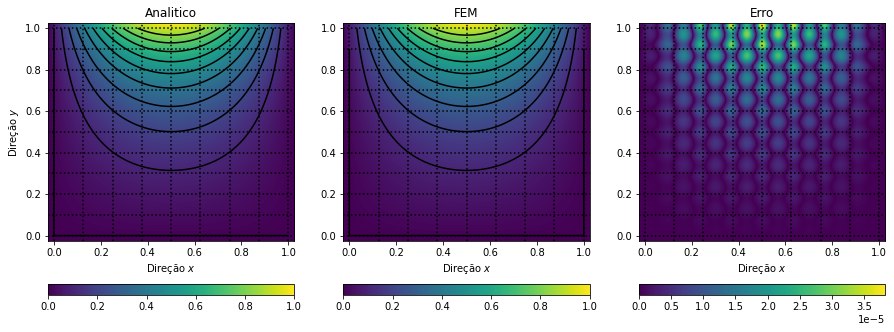

In [20]:
yplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly
exavalues = np.tensordot(np.sin(np.pi*xplot), np.sinh(np.pi*yplot), axes=0)/np.sinh(np.pi)

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, yplot, exavalues, axis[0])
plot_field(xplot, yplot, femvalues, axis[1])
plot_field(xplot, yplot, np.abs(femvalues-exavalues), axis[2], contour=False)
axis[0].set_xlabel(r"Direção $x$")
axis[0].set_ylabel(r"Direção $y$")
axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[1].set_xlabel(r"Direção $x$")
axis[2].set_title("Erro")
axis[2].set_xlabel(r"Direção $x$")
for i in range(3):
    [axis[i].axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
    [axis[i].axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]

### Exercicio 7

> $$\dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} = 0$$ 
>
> No domínio
> 
> $$\Omega = \left(0, \ 1\right) \times \left(0, \ 1\right)$$
>
> E condições de contorno
>
> \begin{align*}
T(x, \ 0) & = 0 \ \ \ \ \ 0 \le x \le 1 \\
T(x, \ 1) & = 1 \ \ \ \ \ 0 \le x \le 1 \\
T(0, \ y) & = 0 \ \ \ \ \ 0 < y < 1 \\
T(1, \ y) & = 0 \ \ \ \ \ 0 < y < 1
\end{align*}

Então resolvemos numericamente

In [21]:
nx, ny = 11, 13
px, py = 3, 4
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

BC_at_x0 = np.zeros(len(ysample))
BC_at_y0 = np.zeros(len(xsample))
BC_at_x1 = np.zeros(len(ysample))
BC_at_y1 = np.ones(len(xsample))
Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = np.linalg.lstsq(Lx.T, BC_at_y0, rcond=0)[0]  # T(x, 0)
Tvals[0, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x0, rcond=0)[0]  # T(0, y)
Tvals[:, ny-1] = np.linalg.lstsq(Lx.T, BC_at_y1, rcond=0)[0]  # T(x, 1)
Tvals[nx-1, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x1, rcond=0)[0]  # T(1, y)

f = lambda x, y: 0
A = mountA(Nx, Ny, 1, 1)
B = mountB(Nx, Ny, xsample, ysample, f)
# Adicionamos a condicao de conxorno de Neumann quando y = 1
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'FEM')

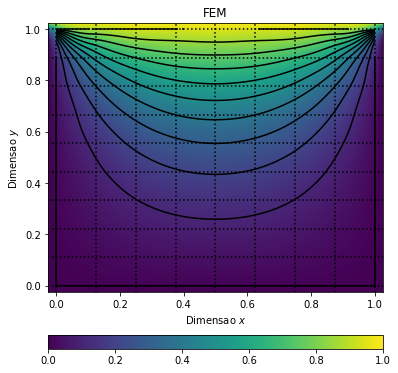

In [22]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly

fig = plt.figure(figsize=(6,6))
axis = plt.gca()
plot_field(xplot, yplot, femvalues, axis)
[axis.axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
[axis.axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]
axis.set_ylabel(r"Dimensao $y$")
axis.set_xlabel(r"Dimensao $x$")
axis.set_title(r"FEM")

### Exercicio 8

Equação do calor bidimensional em regime permanente com geração de calor:
> $$\dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} = -2\pi^2 \sin \left(\pi x\right) \sin \left(\pi y\right)$$ 
>
> No domínio
> 
> $$\Omega = \left(0, \ 1\right) \times \left(0, \ 1\right)$$
>
> E condições de contorno
>
> \begin{align*}
T(x, \ 0) & = 0 \ \ \ \ \ 0 \le x \le 1 \\
T(x, \ 1) & = 0 \ \ \ \ \ 0 \le x \le 1 \\
T(0, \ y) & = 0 \ \ \ \ \ 0 < y < 1 \\
T(1, \ y) & = 0 \ \ \ \ \ 0 < y < 1
\end{align*}

In [23]:
nx, ny = 11, 13
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

BC_at_x0 = np.zeros(len(ysample))
BC_at_y0 = np.zeros(len(xsample))
BC_at_x1 = np.zeros(len(ysample))
BC_at_y1 = np.zeros(len(xsample))
Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = np.linalg.lstsq(Lx.T, BC_at_y0, rcond=0)[0]  # T(x, 0)
Tvals[0, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x0, rcond=0)[0]  # T(0, y)
Tvals[:, ny-1] = np.linalg.lstsq(Lx.T, BC_at_y1, rcond=0)[0]  # T(x, 1)
Tvals[nx-1, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x1, rcond=0)[0]  # T(1, y)

f = lambda x, y: -2*np.pi**2 * np.sin(np.pi*x) * np.sin(np.pi*y)
A = mountA(Nx, Ny, 1, 1)
B = mountB(Nx, Ny, xsample, ysample, f)
Tvals, _ = solve_system(A, B, Tvals)

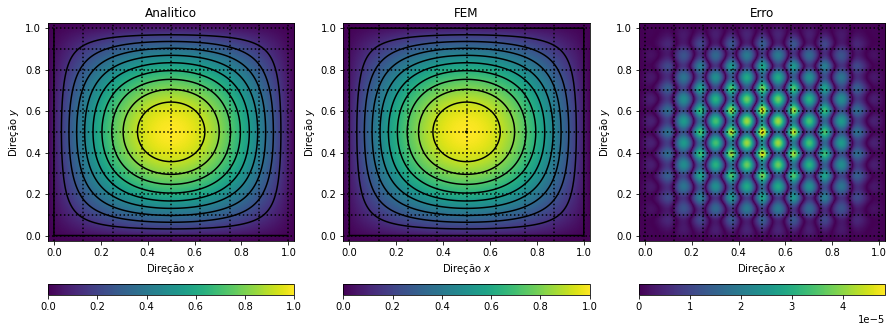

In [24]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly
exavalues = np.tensordot(np.sin(np.pi*xplot), np.sin(np.pi*yplot), axes=0)

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, yplot, exavalues, axis[0])
plot_field(xplot, yplot, femvalues, axis[1])
plot_field(xplot, yplot, np.abs(femvalues-exavalues), axis[2], contour=False)

axis[0].set_title("Analitico")
axis[1].set_title("FEM")
axis[2].set_title("Erro")
for i in range(3):
    axis[i].set_xlabel(r"Direção $x$")
    axis[i].set_ylabel(r"Direção $y$")
    [axis[i].axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
    [axis[i].axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]

### Exercicio 9

> $$\dfrac{\partial^2 T}{\partial x^2}+\dfrac{\partial^2 T}{\partial y^2} = 0$$
> 
> No domínio
> 
> \begin{align*}
S & = \left[0, \ 1\right] \times \left[0, \ 1\right] \\
C & = \left[0.4, \ 0.6\right] \times \left[0.4, \ 0.6\right]  \\
\Omega & = S \setminus C \\
\end{align*}
> 
> And boundary conditions
> 
> \begin{align*}
T(x, \ 0) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\
T(x, \ 1) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\
T(0, \ y) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le y \le 1 \\
T(1, \ y) & = 0   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le y \le 1 \\
T(x, \ y) & = 1   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \forall \left(x, \ y\right) \in C
\end{align*}

Para essa condição no centro, teremos que para $x$ e para $y$ adicionamos os nós $0.4$ e $0.6$.
Desta forma, a solução $T$ é descrita como

$$
T = \left[N_{py}\right] \cdot \left[T \right] \cdot \left[N_{px}\right] = \sum_{j=0}^{n_y-1}\sum_{i=0}^{n_x-1} N_{i,px}(x) N_{j,py} T_{ji}
$$

Sendo $a$, $b$, $c$, $d \in \mathbb{N}$ tal que $x_a = 0.4$, $x_b = 0.6$, $y_c=0.4$ e $y_{d}=0.6$, então todos os pesos $T_{ji}$ (tal que $N_{ij}$ seja não nulo em $\left[u_a, \ u_{a+1}\right]$) são $1$.

Como anteriormente dito

* $N_{ij}(u)$ é não nulo no intervalo $\left[u_{i}, \ u_{i+j+1}\right)$

* Logo, no intervalo $\left[u_{k}, \ u_{k}\right]$ apenas as funções abaixo são não nulas:

$$N_{k-j,j}, \ N_{k-j+1,j}, \ \cdots, \ N_{k-1,j}, \ N_{k, j}$$

Assim, 

$$T_{ji} = 0 \ \ \ \ \ \ \ \ \ \forall \begin{cases}i = a-p_{x}, \ \cdots, \ b \\ j = c-p_y, \ \cdots, \ d\end{cases}$$

In [25]:
nx, ny = 41, 41
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
for U in [Ux, Uy]:
    for knot in [0.4, 0.6]:
        if U.degree == U.mult(knot):
            continue
        U.knot_insert(knot, U.degree-int(U.mult(knot)))
nx, ny = Ux.npts, Uy.npts
spanx04, spanx06 = Ux.span([0.4, 0.6]) 
spany04, spany06 = Uy.span([0.4, 0.6])
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = np.zeros(nx)  # T(x, 0)
Tvals[0, :] = np.zeros(ny)   # T(0, y)
Tvals[:, ny-1] = np.zeros(nx)   # T(x, 1)
Tvals[nx-1, :] = np.zeros(ny)  # T(1, y)
Tvals[spanx04-px:spanx06+1-px, spany04-py:spany06+1-py] = 1

f = lambda x, y: 0
A = mountA(Nx, Ny, 1, 1)
B = mountB(Nx, Ny, xsample, ysample, f)
# Adicionamos a condicao de conxorno de Neumann quando y = 1
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'FEM')

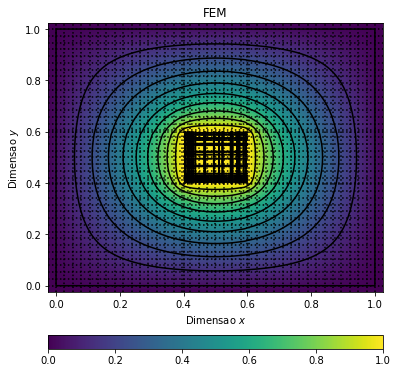

In [26]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly

fig = plt.figure(figsize=(6,6))
axis = plt.gca()
plot_field(xplot, yplot, femvalues, axis)
[axis.axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
[axis.axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]
# axis.plot((0.4, 0.4, 0.6, 0.6, 0.4), (0.4, 0.6, 0.6, 0.4, 0.4), color="w", lw= 5)
axis.set_ylabel(r"Dimensao $y$")
axis.set_xlabel(r"Dimensao $x$")
axis.set_title(r"FEM")

### Exercicio 10

Pegando a inspiração do Exercicio 9, mas aproveitando a simetria ao redor de $x=0.5$ e $y=0.5$, nós reformulamos o problema como:

> $$\dfrac{\partial^2 T}{\partial x^2}+\dfrac{\partial^2 T}{\partial y^2} = 0$$
> 
> No domínio
> 
> \begin{align*}
S & = \left[0, \ 1\right] \times \left[0, \ 1\right] \\
C & = \left[0, \ 0.2\right] \times \left[0, \ 0.2\right]  \\
\Omega & = \left(S \setminus C \right) \\
\end{align*}
> 
> E condições de contorno
> 
> \begin{align*}
\dfrac{\partial T}{\partial y}(x, \ 0) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0.2 < x \le 1 \\
T(x, \ 1) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\
\dfrac{\partial T}{\partial x}(0, \ y) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0.2 < y \le 1 \\
T(1, \ y) & = 0   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le y \le 1 \\
T(x, \ y) & = 1   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \forall \left(x, \ y\right) \in C
\end{align*}

In [27]:
nx, ny = 21, 21
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
knotx, knoty = 0.2, 0.3
if Ux.degree != Ux.mult(knotx):
    Ux.knot_insert(knotx, Ux.degree-int(Ux.mult(knotx)))
if Uy.degree != Uy.mult(knoty):
    Uy.knot_insert(knoty, Uy.degree-int(Uy.mult(knoty)))
    
nx, ny = Ux.npts, Uy.npts
spanx = Ux.span(knotx) 
spany = Uy.span(knoty)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, ny-1] = np.zeros(nx)   # T(x, 1)
Tvals[nx-1, :] = np.zeros(ny)  # T(1, y)
Tvals[:spanx+1-px, :spany+1-py] = 1

f = lambda x, y: 0
A = mountA(Nx, Ny, 1, 1)
B = mountB(Nx, Ny, xsample, ysample, f)

# Adicionar condição de Neumann
xsample = np.linspace(knot, 1, 4*nx)
ysample = np.linspace(knot, 1, 4*ny)
q_at_x0 = np.zeros(ysample.shape, dtype="float64")
q_at_y0 = np.zeros(xsample.shape, dtype="float64")
Lx, Ly = Nx[spanx+1-px:nx-1](xsample), Ny[spany+1-py:ny-1](ysample)
B[0, spany+1-py:ny-1] = np.linalg.lstsq(Ly.T, q_at_x0, rcond=None)[0]
B[spanx+1-px:nx-1, 0] = np.linalg.lstsq(Lx.T, q_at_y0, rcond=None)[0]
Rx = getD(px, Ux) @ Nx[:,px-1](0)
Ry = getD(py, Uy) @ Ny[:,py-1](0)
for i in range(nx):  # 
    A[i, i, 0, :] = Rx[:]
for j in range(ny):
    A[0, :, j, j] = Ry[:]

Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'FEM')

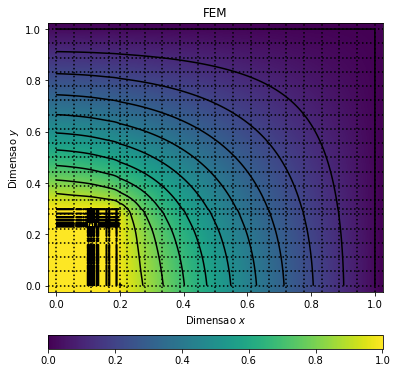

In [28]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly

fig = plt.figure(figsize=(6,6))
axis = plt.gca()
plot_field(xplot, yplot, femvalues, axis)
[axis.axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
[axis.axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]
# axis.plot((0.4, 0.4, 0.6, 0.6, 0.4), (0.4, 0.6, 0.6, 0.4, 0.4), color="w", lw= 5)
axis.set_ylabel(r"Dimensao $y$")
axis.set_xlabel(r"Dimensao $x$")
axis.set_title(r"FEM")